# Линейная регрессия. Работа с признаками

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/ElenaNKn/portfolio_rus/master/project_linear_regression/diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Посмотрим на типы столбцов.

In [3]:
data.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

Таким образом, целевая переменная задается столбцом `price`. Остальные столбцы могут рассматриваться как признаки объекта

## EDA и проектирование признаков

Проверим количество пропусков в каждом столбце.

In [4]:
data.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

Столбец `Unnamed: 0` не несет смысловой информации. Поэтому удалим его

In [5]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной.  Проверим, насколько эта связь выполняется. Для этого построим матрицу корреляций между всеми вещественными признаками и целевой переменной.

In [6]:
list_num = ['carat', 'depth', 'table', 'x', 'y', 'z']

corr = data[list_num].corrwith(data['price']).abs().sort_values(ascending=False)
print(corr)

carat    0.921591
x        0.884435
y        0.865421
z        0.861249
table    0.127134
depth    0.010647
dtype: float64


Как видно  из полученных коэффициентов корреляции Пирсона, цена бриллианта преимущественно определяется его весом в каратах и ленейными размерами.

Для моделей линейной регрессии нежелательно наличие сильной линейной связи между признаками. Проверим попарные коэффициенты корреляции числовых признаков

In [7]:
corr_matr = data[list_num].corr()
corr_matr

,carat,depth,table,x,y,z
carat,1.000000,0.028224,0.181618,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.195344,0.183760,0.150929
x,0.975094,-0.025289,0.195344,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.970772,0.952006,1.000000


Из полученных результатов видно, что линейные размеры (`x`, `y`, `z`) сильно коррелируют между собой, а также с признаком веса (`carat`). То есть мы столкнулись с проблемой мультиколлинеарности. При этом, ранее было показано, что целевая переменная `price` лучше коррелирует с признаком `carat`, чем с линейными размерами.

В данной ситуации можно удалить признаки `x`, `y` и `z`

In [8]:
data.drop(['x', 'y', 'z'], axis=1, inplace=True)

Посмотрим, как изменилась матрица корреляций числовых признаков и коэффициенты корреляции с целевой переменной

In [9]:
list_num = ['carat', 'depth', 'table']

corr_matr = data[list_num].corr()
corr_matr

,carat,depth,table
carat,1.000000,0.028224,0.181618
depth,0.028224,1.000000,-0.295779
table,0.181618,-0.295779,1.000000


In [10]:
corr = data[list_num].corrwith(data['price']).abs().sort_values(ascending=False)
print(corr)

carat    0.921591
table    0.127134
depth    0.010647
dtype: float64


Теперь посмотрим, как влияют категориальные признаки на цену бриллиантов. Для этого рассчитаем взаимную информацию

In [11]:
def mutual_info(series):
    return mutual_info_score(series, data['price'])

In [12]:
list_categorical = ['cut', 'color', 'clarity']
mi = data[list_categorical].apply(mutual_info)
mi.sort_values(ascending=False)

clarity    0.883855
color      0.849440
cut        0.483690
dtype: float64

Таким образом, мы видим, что чистота и цвет влияют значительно больше на конечную цену бриллианта, чем способ его огранки 

Посмотрим, как распределена целевая переменная, чтобы оценить есть ли необходимость дополнительного преобразования целевой переменной (например, в случае наличия "длинного хвоста")

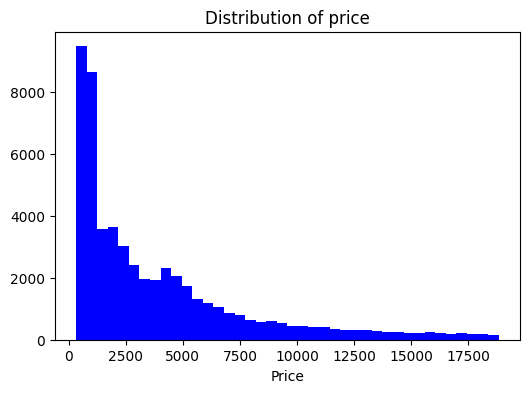

In [13]:
plt.figure(figsize=(6, 4))

plt.hist(data['price'], bins=40, color='blue')
plt.xlabel('Price')
plt.title('Distribution of price')

plt.show()

Визуально распределение цены напоминает экспоненциальное распределение, необходимости в дополнительных преобразованиях не наблюдается

## Подготовка данных

Формируем матрицу признаков Х и вектор целевой переменной у (для `price`).

In [14]:
X = data.drop('price', axis=1)
y = data.price

Разбиваем выборку на тренировочную и тестовую часть.

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state = 42)

Закодируем категориальные переменные при помощи OneHot-кодирования. Для исключения возникновения линейной зависимости между закодированными признаками ставим drop_first= True.

In [16]:
transformer = make_column_transformer((OneHotEncoder(drop='first'), list_categorical), remainder="passthrough")
transformed = transformer.fit_transform(Xtrain).toarray()
Xtrain = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

transformed_test=transformer.transform(Xtest).toarray()
Xtest=pd.DataFrame(transformed_test, columns=transformer.get_feature_names_out())

Линейные модели чувствительны к масштабам. Поэтому отнормируем выборки с применением StandardScaler

In [17]:
scaler = StandardScaler()

Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns, index=Xtrain.index)
Xtest = pd.DataFrame(scaler.transform(Xtest), columns=Xtest.columns, index=Xtest.index)
Xtrain.head()

,onehotencoder__cut_Good,onehotencoder__cut_Ideal,onehotencoder__cut_Premium,onehotencoder__cut_Very Good,onehotencoder__color_E,onehotencoder__color_F,onehotencoder__color_G,onehotencoder__color_H,onehotencoder__color_I,onehotencoder__color_J,onehotencoder__clarity_IF,onehotencoder__clarity_SI1,onehotencoder__clarity_SI2,onehotencoder__clarity_VS1,onehotencoder__clarity_VS2,onehotencoder__clarity_VVS1,onehotencoder__clarity_VVS2,remainder__carat,remainder__depth,remainder__table
0,-0.314881,1.227398,-0.585893,-0.539653,-0.470813,-0.465474,-0.511867,2.329335,-0.333294,-0.234494,-0.184885,-0.568277,-0.451216,-0.422668,-0.542475,-0.270252,3.121212,0.862659,-0.311437,-0.207099
1,-0.314881,1.227398,-0.585893,-0.539653,2.123985,-0.465474,-0.511867,-0.429307,-0.333294,-0.234494,-0.184885,-0.568277,-0.451216,-0.422668,1.843403,-0.270252,-0.320388,-1.029889,0.178549,-0.656213
2,-0.314881,1.227398,-0.585893,-0.539653,2.123985,-0.465474,-0.511867,-0.429307,-0.333294,-0.234494,-0.184885,-0.568277,-0.451216,2.365922,-0.542475,-0.270252,-0.320388,0.862659,0.458541,-0.207099
3,-0.314881,1.227398,-0.585893,-0.539653,-0.470813,2.148350,-0.511867,-0.429307,-0.333294,-0.234494,-0.184885,-0.568277,2.216235,-0.422668,-0.542475,-0.270252,-0.320388,0.021527,0.598537,-1.105327
4,-0.314881,1.227398,-0.585893,-0.539653,-0.470813,-0.465474,-0.511867,-0.429307,3.000353,-0.234494,-0.184885,-0.568277,-0.451216,-0.422668,-0.542475,-0.270252,3.121212,-0.020530,-0.031445,-0.656213


## Построение модели

Обучим линейную регрессию на тренировочной выборке. Проверим качество модели с помощью *r2-score* на тренировочной и тестовой выборках.

In [18]:
model = LinearRegression()
model.fit(Xtrain, ytrain)

LinearRegression()

In [19]:
prediction = model.predict(Xtrain)
r2_train = r2_score(prediction, ytrain)

print(r2_train)

0.9082617514220505


In [20]:
prediction = model.predict(Xtest)
r2_test = r2_score(prediction, ytest)

print(r2_test)

0.9087636758594968


Выведем на экран веса, которые линейная регрессия присвоила признакам.

In [21]:
features = Xtrain.columns
weights = model.coef_
feature_weights = pd.DataFrame({'Feature': features, 'Weight': weights})
feature_weights

,Feature,Weight
0,onehotencoder__cut_Good,178.492234
1,onehotencoder__cut_Ideal,431.385520
2,onehotencoder__cut_Premium,355.343915
3,onehotencoder__cut_Very Good,328.657369
4,onehotencoder__color_E,-84.371022
5,onehotencoder__color_F,-117.291229
6,onehotencoder__color_G,-213.029774
7,onehotencoder__color_H,-359.719840
8,onehotencoder__color_I,-434.463167
9,onehotencoder__color_J,-519.441073


Модель линейной регрессии позволяет оценить, насколько значим каждый признак для определения значения целевой переменной. Анализируя коэффициенты полученной модели  линейной регрессии мы видим, что цена бриллианта определяется преимущественно его весом в каратах и чистотой. Остальные признаки гораздо менее значимы

## Получение предсказания

In [22]:
obj = {'carat': 0.28, 'cut': 'Ideal', 'color': 'I', 'clarity': 'VS2', 'depth': 63.5, 'table': 63.0, 'index':[0]}

Зададим функцию для обработки входных данных для произвольного объекта

In [23]:
def obj_preproc(obj, transformer, scaler):
    """
    This function preprocess input object characteristics to sent them to the model
    obj - dictionary with object characteristics;
    transformer - ColumnTransformer object to apply OneHotEncoding
    scaler - StandardScaler object to standatrize features of the input object
    """
    
    obj = pd.DataFrame.from_dict(obj, orient='columns')

    transformed_object = transformer.transform(obj).toarray()
    obj = pd.DataFrame(transformed_object, columns=transformer.get_feature_names_out())

    obj = pd.DataFrame(scaler.fit_transform(obj), columns=obj.columns, index=obj.index)
    
    return obj

Применим функцию к нашему произвольному объекту и на основе вышепостроенной модели линейной регрессии предскажем значение целевой переменной

In [24]:
obj = obj_preproc(obj, transformer, scaler)

In [25]:
prediction = model.predict(obj)
print(round(prediction[0], 1))

3951.5


# Выводы

В рамках данного проекта был рассмотрен датасет с характеристиками и стоимостью бриллиантов.

Выполненный анализ датасета (EDA) показал присутствие в нем сильно коррелирующих признаков, а именно линейных размеров и веса. Для избежания проблемы мультиколлениарности линейные размеры были исключены из числа признаков.

Выполнена обработка датасета: one-hot-encoding категориальных признаков и стандартизация всех признаков датасета (возможен был вариант раздельной обработки, а именно кодирования категориальных признаков и стандартизации числовых, но в большинстве источников рекомендуется все-таки для закодированных признаков также применять стандартизацию).

Построена модель линейной регрессии. R2-score для модели составил 0,908 на обучающей и тестовой выборках, что для линейной модели достаточно неплохо. В целом построенная модель может использоваться в качестве baseline при построении более сложных моделей.

Анализ весовых коэфффициентов модели показал, что цена бриллианта определяется преимущественно его весом в каратах и чистотой. Остальные признаки гораздо менее значимы.

Получено предсказание для объекта (бриллианта) с произвольными характеристиками, что может стать основой для разработки веб-сервиса на основе модели.